### Aim:
- Aims to transform the original features of a dataset into a new set of **Uncorrelated variables** called **Principal Components** with the objective of retaining the most important information while discarding the least important.
  - This process effectively removes redundancy in the data and helps in simplifying the representation of the dataset.

Note: PCA is effective in reducing correlation among the principal components, especially when a significant portion of the variance is captured by the retained components. However, it's essential to recognize that the degree of correlation reduction may vary depending on the data characteristics and the number of principal components retained.

![pca 2d showing redundancy removal](images/pca_2d.png)

![covariance matrices](images/covar_pca_2d.png)

### Objective of PCA

- Identify the directions of new axes where variance is maximized.
- Project the data points onto these new axes with minimum reconstruction error.

### Let's start with a simple case:

Suppose we want to project the entire dataset, regardless of its dimensionality, onto a single principal component

We have two objectives to fulfill when projecting the entire dataset onto a single principal component, which essentially represents a line.

- Identify the direction of this line where the variance is maximized.
- Project the data points onto this new axis (line) with minimum reconstruction error.

**Let's start with the second objective. Suppose we've already found the best direction for the new axis:**

Now, with the optimal direction for the new axis, we aim to achieve the following goals while minimizing reconstruction errors:

1. Figuring out where the original data points should be placed along the new axis.
2. Deciding where this new axis should be positioned within the current coordinate system. (At this point, we only know the direction of the new axis.)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider

<IPython.core.display.Javascript object>


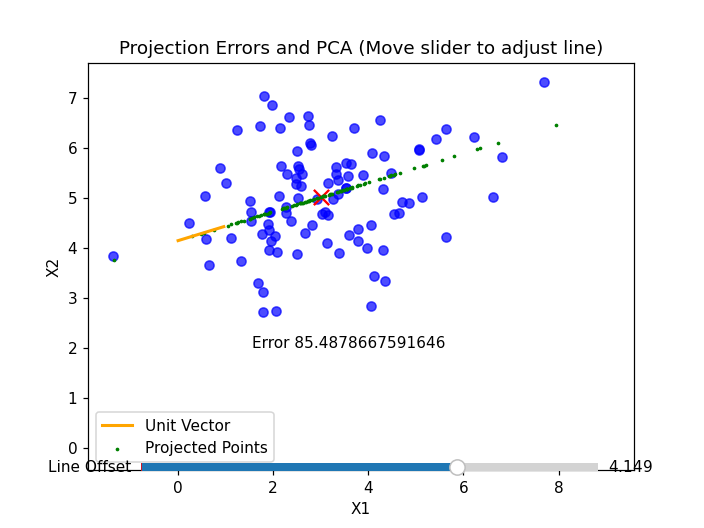

In [247]:
%matplotlib notebook

# --- Generate sample data ---
rng = np.random.default_rng()
data = rng.multivariate_normal([3, 5], [[2, 0.5], [0.5, 1]], size=100)

# --- Calculate mean and covariance ---
data_mean = np.mean(data, axis=0)
centered_data = data - data_mean
cov_matrix = np.cov(centered_data.T)

# --- Find the primary direction (first principal component) ---
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
pc1_direction = eigenvectors[:, np.argmax(eigenvalues)]
pc1_direction = pc1_direction.reshape(-1, 1)

def project_points(data, unit_vector, y_offset):

    Z = np.array([0, y_offset]) # Translate the origin to (0, y_offset)
    
    # Let's project the original data point on this new line
    projected_points = []
    for point in data:
        PZ = point - Z # Translate the point relative to Z
        proj = (np.dot(PZ.reshape(1, 2), unit_vector).flatten()[0] / np.dot(unit_vector.T, unit_vector)) * unit_vector
        projected_point = Z.reshape(-1, 1) + proj # Translate back to the original coordinate system
        projected_points.append(projected_point)

    return np.array(projected_points).reshape(-1, 2)

def projection_error(data, direction, offset):
    # Project the data points onto the line defined by the direction vector and offset
    projected_points = project_points(data, direction, offset[1])
    
    # Calculate the squared distances between the original data points and their projections
    errors = np.linalg.norm(data - projected_points, axis=1) ** 2
    
    # Return the sum of squared errors
    return projected_points, np.sum(errors)

fig, ax = plt.subplots()

# Plot data and mean
ax.scatter(data[:, 0], data[:, 1], c='blue', alpha=0.7)
ax.scatter(data_mean[0], data_mean[1], c='red', marker='x', s=100)

# Initialize line position and plot the initial line
y_offset = 0
line, = ax.plot([0, pc1_direction[0]], [y_offset, pc1_direction[1] + y_offset], 
                color='orange', linestyle='-', linewidth=2, label='Unit Vector')

# Calculate initial projection and error
projected_points, error = projection_error(data, pc1_direction, [0, y_offset])
proj_points = ax.scatter(projected_points[:, 0], projected_points[:, 1], c='green', label='Projected Points', s=2)
error_text = ax.text(0.3, 0.3, f'Error {error}', transform=ax.transAxes)

# Update function for slider movement
def update(val):
    global y_offset
    y_offset = val
    line.set_ydata([y_offset, pc1_direction[1] + y_offset])
    new_projected_points, error = projection_error(data, pc1_direction, [0, y_offset]) 
    proj_points.set_offsets(new_projected_points) 
    error_text.set_text(f'Error {error}')
    fig.canvas.draw_idle()

# Slider for offset adjustment
ax_slider = fig.add_axes([0.2, 0.1, 0.65, 0.03])
slider = Slider(ax=ax_slider, label='Line Offset', valmin=0, valmax=6, valinit=y_offset)
slider.on_changed(update)

# Labels and title
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_title('Projection Errors and PCA (Move slider to adjust line)')
ax.legend()
plt.show()